<span style="font-size: 120%">Cluster the bullet items of the job postings and visualize the clusters using word clouds and graphs. Allowing for one to interpret the different types of job requirements and their distribution (which cluster has the most/least items: which is related to which requirements are most solicited by employers).</span>


In [1]:
from sklearn.cluster                 import KMeans
from sklearn.preprocessing           import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition           import TruncatedSVD

%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy  as np

from wordcloud import WordCloud

import functools as ft
import gzip
import importlib
import json
import multiprocessing as mp
import os
import pickle
import random
import time


In [2]:
ngram_param = None
with open('config.json') as f:
    ngram_param = tuple(json.load(f)['ngram_range'])
ngram_param

(1, 1)

In [3]:
# select which part of the job postings HTML likely contains 
# the listed job requirements of a given posting

jobs_df = pd.read_pickle('data/sorted_trunc_jobs_df.pkl', 'zip')
jobs_df['li_elems']

0     (Take high-level project requirements and form...
1     (Take high-level project requirements and form...
2     (Organize, transform, and verify the integrity...
3     (Perform hands-on analysis of large volumes of...
4     (Perform hands-on analysis of large volumes of...
                            ...                        
75    (Design, build, and deploy innovative models a...
76    (Lead advanced analytics and data science team...
77    (Experience with programming in Python, R, or ...
78    (Work collaboratively within cross-functional ...
79    (Identify valuable data sources and automate c...
Name: li_elems, Length: 80, dtype: object

In [4]:
job_reqs = [ i for subiter in jobs_df['li_elems'] for i in subiter ]

# store job_reqs for more expedient use later in notebook 4_analysis.ipynb
with open('data/job_reqs_list.pkl', 'wb') as f:
    pickle.dump(job_reqs, f)

In [5]:
# vectorize the job requirements

vocab = TfidfVectorizer(ngram_range=ngram_param ,stop_words='english')
freq_matrix = vocab.fit_transform(job_reqs)
freq_matrix.shape

(1465, 2576)

In [6]:
# - reduce dimensionality with SVD/LSA 
# - see how much explained variance is retained for increasing features

svd = TruncatedSVD(n_components=1000)
svd.fit(freq_matrix)

for i in range(1,10):
    print(svd.explained_variance_ratio_[:(i*100)].sum())

0.4182291204833987
0.5820931915017867
0.6912850927530528
0.7714519347748906
0.834391143607294
0.8844755333366904
0.9238464998094542
0.954005228809888
0.9758528054099711


In [7]:
# documentaion recomends n_components=100 but here increasing 
# n_components is resulting in a more informative mix of focus
# and broadness in the topics upon inspection

svd      = TruncatedSVD(n_components=500)
fm_reduc = svd.fit_transform(freq_matrix)
norm_fmr = Normalizer().fit_transform(fm_reduc)

In [8]:
# - select appropriate cluster count for k-means
# - Run algorithm using range of centroids, then analyze results and 
#   end goal of using k-means (creating job requirement clusters with
#   right balance of scope versus focus in order to be useful).

k_range_max = 20
k_range = range(1, k_range_max+1)

def runKmeans(k):
    return (KMeans(n_clusters=k, n_init=20, random_state=0)
            .fit(norm_fmr).inertia_)

In [9]:
within_sum_sqs = []
with mp.Pool(os.cpu_count()) as p_pool:
    within_sum_sqs = p_pool.map(runKmeans, k_range)

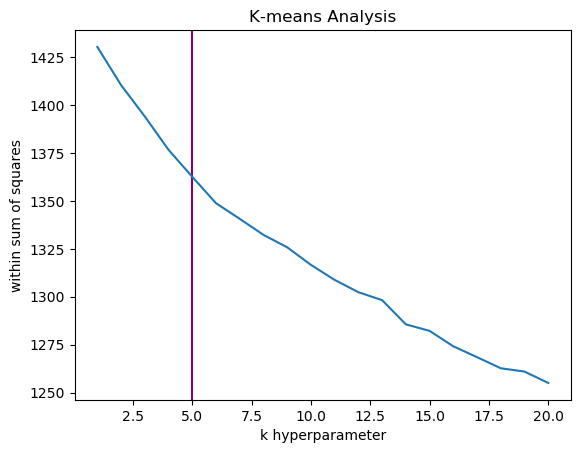

In [10]:
k = 5

plt = importlib.reload(plt)
plt.title('K-means Analysis')
plt.xlabel('k hyperparameter')
plt.ylabel('within sum of squares')
plt.axvline(k, color='purple')
plt.plot(k_range, within_sum_sqs)

# elbow method, let k = 5
k_means = KMeans(n_clusters=k,
                 n_init=20,
                 random_state=0).fit(norm_fmr)
# WARNING this implementation of k-means is nondeterministically assigning labels
# each cluster each time the algorithm is run, but the clusters will remain the 
# same if using random_state=<integer>

In [11]:
# save choice for k in config file
with open('config.json', 'r+') as f:
    config = json.load(f)
    config['k_hyperparam'] = k
    f.seek(0)
    f.write(json.dumps(config, indent=2))

# collect clustering results
clust_labels_df = pd.DataFrame({'cluster':list(map(lambda x: x+1, k_means.labels_))})
clust_labels_df.to_pickle('data/clust_labels_df.pkl', 'zip')
print(clust_labels_df)

      cluster
0           1
1           1
2           1
3           1
4           1
...       ...
1460        1
1461        1
1462        1
1463        1
1464        1

[1465 rows x 1 columns]


In [12]:
# with word clouds, view contents of clusters

In [13]:
def clust_to_img(clust_df):
    indexes = clust_df.index.values
    summed_score = np.asarray(freq_matrix[indexes].sum(axis=0))[0]
    data = {
        'word':vocab.get_feature_names(),
        'summed_tfidf_score':summed_score}
    scored_words_df = pd.DataFrame(data).sort_values(
        'summed_tfidf_score', ascending=False)

    cloud = WordCloud(
        max_words=13,
        random_state=0,
        background_color='white',
        color_func = lambda *args, **kwards:
            random.choice(('red','blue','purple','brown','black')))
    
    word_rank = {}; 
    for word, rank in scored_words_df.values:
        if rank != 0:
            word_rank[word] = rank
    
    cloud_img = cloud.fit_words(word_rank) 
    return scored_words_df, cloud_img
    

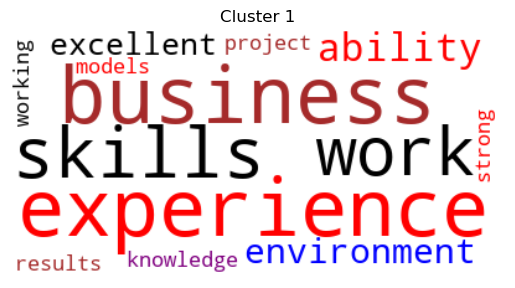

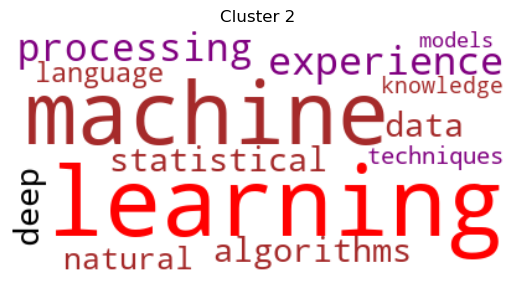

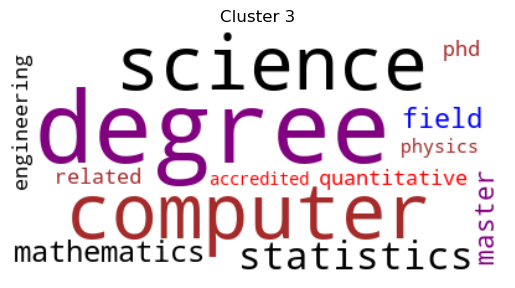

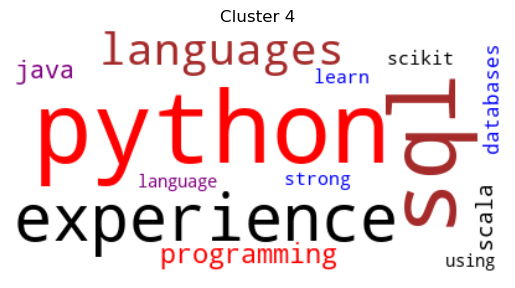

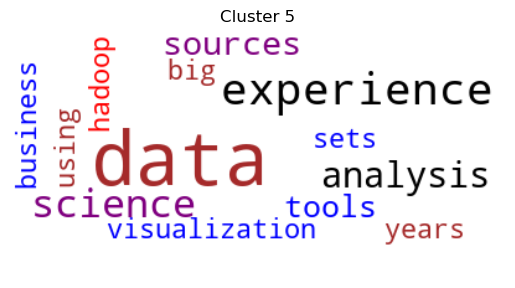

In [14]:
# display word clouds, see if they are sensible

clust_doc_count = {}  # collect to analyze distribution later
clust_words = {} 

for clust in range(1, k+1):
    clust_df = clust_labels_df[clust_labels_df.cluster == clust]
    
    clust_doc_count[clust] = clust_df.shape[0]
    
    scored_words_df, cloud_img = clust_to_img(clust_df)
    clust_words[clust] = scored_words_df['word'].tolist()
    
    plt.title(f"Cluster {clust}")
    plt.imshow(cloud_img, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Results make sense, I can see a range of requirements that 
# are familiar. E.g. I see one cluster emphasizing undergraduate 
# and graduate degrees in quantitative areas and another
# highlighting communication/visualization of data.
# these can be thought of as types of job requirements

{1: 774, 2: 179, 3: 79, 4: 122, 5: 311}


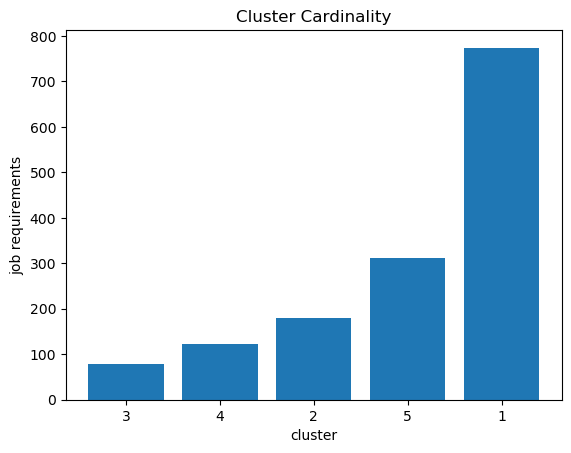

In [15]:
# examine the clusters' cardinalities to get a sense of their distribution
print(clust_doc_count)
cdc_sorted = { str(k):v for k,v in sorted(clust_doc_count.items(), key=lambda x: x[1]) }

plt.title('Cluster Cardinality')
plt.bar(cdc_sorted.keys(), cdc_sorted.values());
plt.xlabel('cluster')
plt.ylabel('job requirements');

# The majority of bullet points (job requirements) have been assigned
# to cluster 1. Which makes sense upon examining the word cloud of that
# cluster as the terms data, business, work, ability, analysis are easily 
# perceived as more general and hence they would overlap more job postings.

In [16]:
# save the displayed words of word clouds for notebook 4_analysis.ipynb
with open('data/clust_words.pkl', 'wb') as f:
    pickle.dump(clust_words, f)